In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [62]:
## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [63]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [64]:
## What signals do we have?

print(df1.columns.values)

['DATETIME' 'L_T1' 'L_T2' 'L_T3' 'L_T4' 'L_T5' 'L_T6' 'L_T7' 'F_PU1'
 'S_PU1' 'F_PU2' 'S_PU2' 'F_PU3' 'S_PU3' 'F_PU4' 'S_PU4' 'F_PU5' 'S_PU5'
 'F_PU6' 'S_PU6' 'F_PU7' 'S_PU7' 'F_PU8' 'S_PU8' 'F_PU9' 'S_PU9' 'F_PU10'
 'S_PU10' 'F_PU11' 'S_PU11' 'F_V2' 'S_V2' 'P_J280' 'P_J269' 'P_J300'
 'P_J256' 'P_J289' 'P_J415' 'P_J302' 'P_J306' 'P_J307' 'P_J317' 'P_J14'
 'P_J422' 'ATT_FLAG']


In [65]:
## Finding correlation

correlation = df1.corr()
correlated_data= correlation
# correlation = correlation.abs()
correlation = correlation.unstack()
corr = correlation.sort_values(kind="quicksort",ascending=False)


## Autocorrelation
df1_columns = df1.columns.values.tolist()
df1_columns.remove('DATETIME')
df1_columns.remove('ATT_FLAG')
dw_stat = pd.Series(sm.stats.durbin_watson(df1[df1_columns]))

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:47: RuntimeWarning: invalid value encountered in true_divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


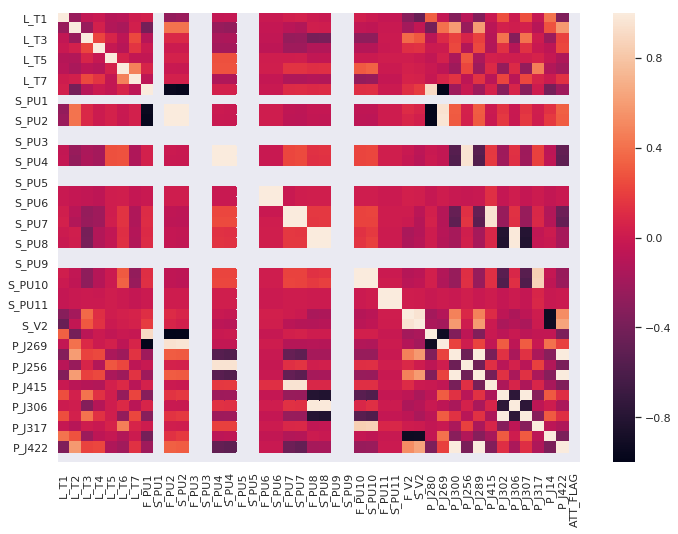

In [66]:
## Heatmap all signals

sns.heatmap(correlated_data)

In [67]:
## Sort correlation for later use

corr = corr.to_frame().reset_index()
corr.columns = ["1","2","correlation"]

corr = corr[corr["correlation"] != 1]
corr = corr[corr["1"] != "ATT_FLAG"]
corr = corr.dropna()


In [68]:
correlheat = correlated_data

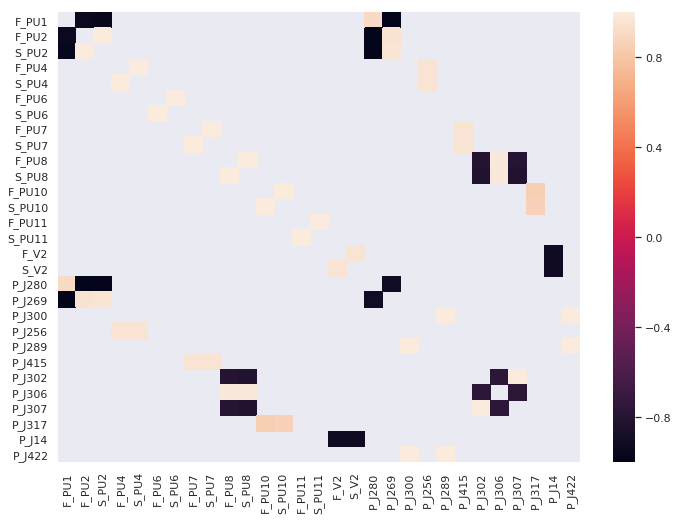

In [69]:
## Plot only most correlated values

correlheat = correlheat.drop("ATT_FLAG",axis=1)
correlheat = correlheat[correlheat != 1]
correlheat = correlheat[abs(correlheat) > 0.7]
correlheat = correlheat.dropna(axis=1,how="all")
correlheat = correlheat.dropna(axis=0, how ="all")
sns.heatmap(correlheat)

Text(0.5, 1.0, 'Correlation with Attacks')

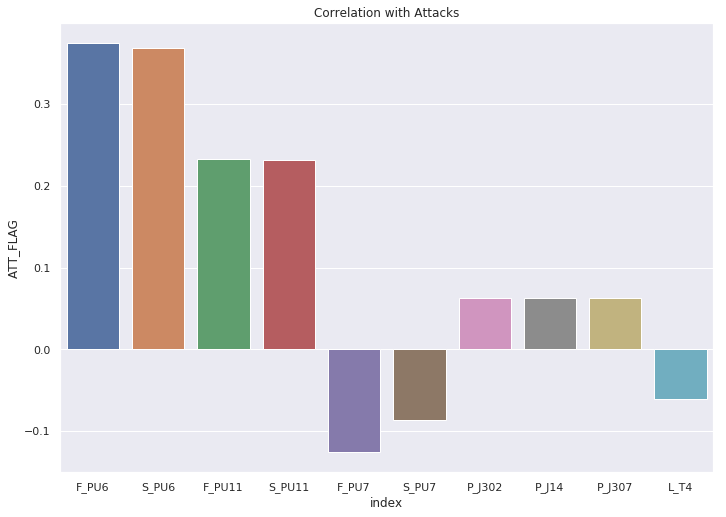

In [70]:
## Correlation with ATT_FLAG:
att_correlation = pd.DataFrame(df2.corr()['ATT_FLAG'])
att_correlation['abs'] = att_correlation['ATT_FLAG'].abs()
att_correlation.sort_values(by='abs', inplace=True, ascending=False)
sns.barplot(data=att_correlation.reset_index().head(11)[1:], x='index', y='ATT_FLAG').set_title("Correlation with Attacks")

In [84]:
## Show most correlated signals
att_correlation.head(11)[1:]

,ATT_FLAG,abs
F_PU6,0.374339,0.374339
S_PU6,0.367945,0.367945
F_PU11,0.232579,0.232579
S_PU11,0.231946,0.231946
F_PU7,-0.125574,0.125574
S_PU7,-0.086880,0.086880
P_J302,0.063321,0.063321
P_J14,0.062989,0.062989
P_J307,0.062262,0.062262
L_T4,-0.060476,0.060476


In [86]:
att_correlation.head(20)[1:].index

Index(['F_PU6', 'S_PU6', 'F_PU11', 'S_PU11', 'F_PU7', 'S_PU7', 'P_J302',
       'P_J14', 'P_J307', 'L_T4', 'P_J317', 'L_T1', 'F_PU1', 'P_J269',
       'F_PU10', 'F_V2', 'S_PU10', 'P_J422', 'S_PU2'],
      dtype='object')

In [72]:
idx = len(df1) - 1 if len(df1) % 24 else len(df1)
test = df1[:idx].groupby(df1.index[:idx] // 24).mean()

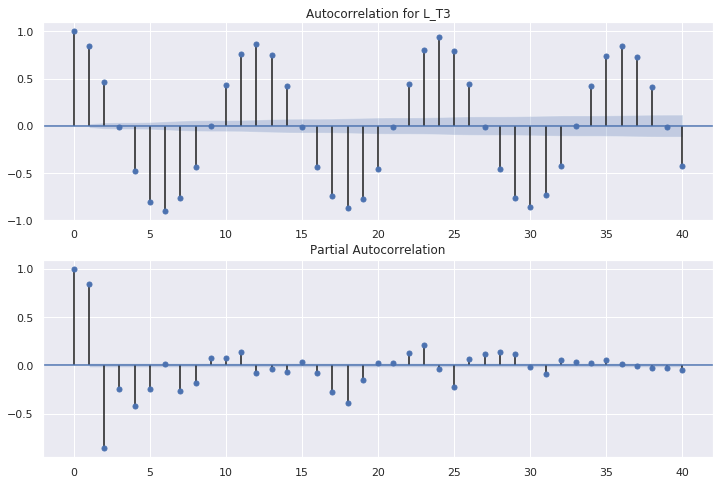

In [73]:
## Plot autocorrelations -> wow, it is cyclic :0

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
testvariable = "L_T3"
fig = sm.graphics.tsa.plot_acf(df1[testvariable].values.squeeze(), lags=40, ax=ax1,title = "Autocorrelation for {}".format(testvariable))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1[testvariable], lags=40, ax=ax2)

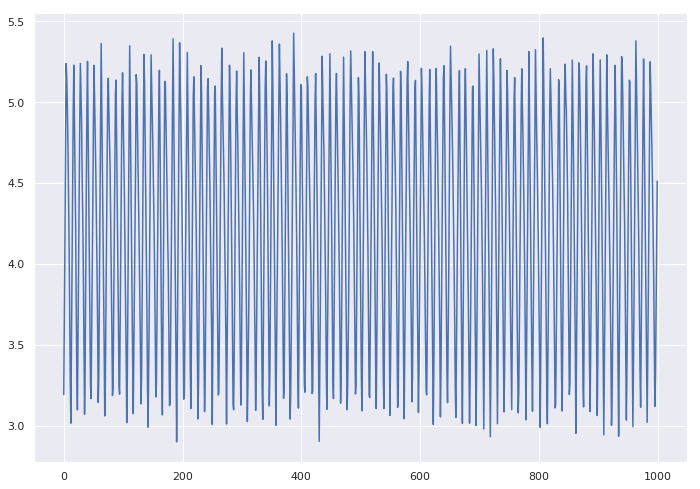

In [74]:
## Again show the cyclic behaviour 
sns.lineplot(data=df1["L_T3"][0:1000])

In [78]:
def create_sliding(small_df, slide_size):
    column_names = small_df.columns.values.tolist()
    feature_df = pd.DataFrame(columns=[x + '_' + str(i) for x in column_names for i in range(slide_size)])
    target_df = pd.DataFrame(columns=[x + '_goal' for x in column_names])
    
    target_df = small_df.iloc[sliding_width:, :].copy().reset_index(drop=True)
    
    
    for offset in range(len(small_df)-slide_size):
        for x in range(slide_size):
            feature_df.loc[offset, [clm + '_' + str(x) for clm in column_names]] = small_df.iloc[offset+x, :].values
    return feature_df, target_df

In [79]:
## Predicting the next value
## We will use sliding windows 

sliding_width = 10
small_df = df1.iloc[:10000, :]    
feature_df, target_df = create_sliding(small_df.loc[:,['L_T1']], sliding_width)

In [80]:
from sklearn.neural_network import MLPRegressor


In [81]:
## Train an MLP on the windows

classifier = MLPRegressor()
classifier.fit(feature_df.iloc[:int(len(feature_df)/2)+1, :], target_df.loc[:int(len(feature_df)/2), 'L_T1'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

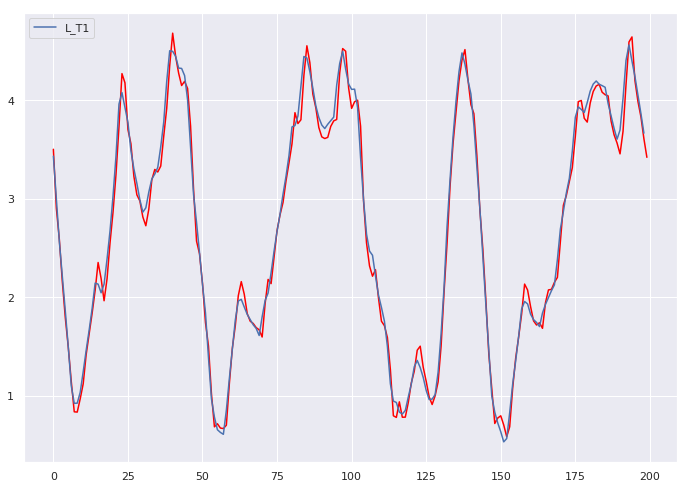

In [82]:
## Plot the predictions and targets

fig, ax = plt.subplots()
sns.lineplot(data=classifier.predict(feature_df.loc[int(len(feature_df)/2+1):int(len(feature_df)/2+200), :]), ax=ax, color="red")
sns.lineplot(data=target_df.iloc[int(len(feature_df)/2+1):int(len(feature_df)/2+200), :].reset_index(drop=True), ax=ax)

In [87]:
source_df = df1
target_df = df2
